# Neural Style Transfer

Neural style transfer is an optimization technique used to take two images, a content image, a style reference image and blend them together such that the output image is transformed to look like the content image, but “painted” in the style of the style image.

The principle of neural style transfer is to define two distance functions, one that describes how different the content of two images are, and one that describes the difference between the two images in terms of their style. Then, given two images, a desired style image, a desired content image, we try to transform the content image to minimize the content distance with the content image and its style distance with the style image.
In summary, we’ll take  a content image that we want to match, and the style image that we want to match. We’ll transform the content image by minimizing the content and style distances (losses) with backpropagation, creating an image that matches the content of the content image and the style of the style image.

### Process outline:

Custom pretrained-model -> obtain_actual_style_content_outputs -> stylize_training_image -> output_stylized_image

## Implementation:

## Importing the necessary packages:

In [1]:
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import PIL
import IPython.display as display
import time


## Loading content and style images:

In [2]:
# matplotlib.pyplot.imread() is used to import an image
# from a specified path and convert it into a numpy array

content_image = plt.imread('images/content_image.jpg')
style_image = plt.imread('images/style_image.jpg')

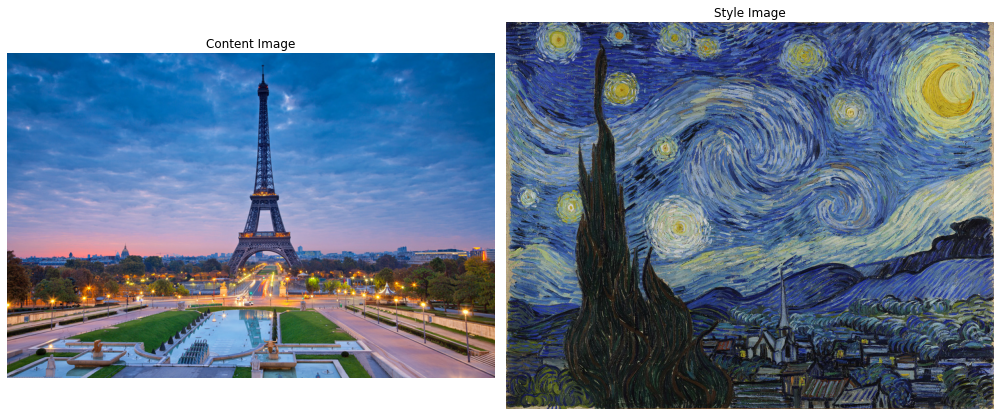

In [3]:
# Creating two subplots 
fig, axes = plt.subplots(1, 2, figsize=(14,7))

# Displaying content and style images 
axes[0].imshow(content_image)
axes[0].set_title('Content Image')
axes[0].axis('off')

axes[1].imshow(style_image)
axes[1].set_title('Style Image')
axes[1].axis('off')

plt.tight_layout()

## Loading VGG19 model:

The module tf.keras.applications contains a variety of popular neural network architectures including Inception net, ResNet, VGG, etc with pre-trained weights.

We are going to use the VGG19 model in this implementation - ***tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')***

### Resources:<br/>
<a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications'>tf.keras.applications</a><br/>
<a href='http://www.image-net.org/'>Imagenet</a>


In [4]:
'''
include_top: Adds the last 3 fully connected layers (fc1, fc2, predictions) to our model. 
             Since our objective is not class predcition, we can exclude these layers.

weights:     Used to load pre-trained weights into the model. We are using 'imagenet' (trained on Imagenet).
'''
VGG19 = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')

# Setting VGG19.trainable to false because the model is pre-trained.
VGG19.trainable = False

'''
Uncomment to print the layer names

VGG19_layers = [layer.name for layer in VGG19.layers]
for layer in VGG19_layers:
    print(layer)
''';

### Resizing content and style images:

The VGG19 model takes in as input a **tf.Tensor** of shape=(None, None, None, 3) -> (batch_size, height, width, channels). By default, the input dimensions are (224, 224, 3) (or) 224\*224 pixels. If our input image has a much higher or much lower resolution, the model fails to fit it properly. Thus, it becomes necessary to either upscale or downscale our input image and add the extra dimension *batch_size* to denote the no.of images (1 here) in the input. 

***tf.image.convert_image_dtype(images, dtype): ***Convert image to dtype, scaling its values if needed. Images that are represented using floating point values are expected to have values in the range 0 to 1. This function converts between data types and  scales the values appropriately. 

***tf.image.resize(images, size, preserve_aspect_ratio): ***Used to resize the image, size is of shape=(a, b). **preserve_aspect_ratio** is used to maintain the aspect ratio. 

***tf.newaxis*** adds another dimension to the image. This dimension is used to denote the batch_size (no of images in the tensor/numpy.array).

In [5]:
# Uncomment to check 
# VGG19.input

In [6]:
def resize_image(input_image):

    # Convert input_image's datatype to float since tf.keras.applications.vgg19.preprocess_input() 
    # accepts inputs of type float only.
    image = tf.image.convert_image_dtype(input_image, dtype=tf.float32, saturate=True)
    
    
    # Resize the image 
    resized_image = tf.image.resize(image, (512, 512), preserve_aspect_ratio = True)
    
    # Add a new dimension to indicate the batch_size. 
    resized_image = resized_image[tf.newaxis, ]

    return resized_image


In [7]:
resized_content_image = resize_image(content_image)
resized_style_image = resize_image(style_image)

In [8]:
'''
Helper function to display a tensor.
'''
def show_image(training_image):

    # Convert tensor to numpy, remove the first dimension(indicating that there is only one image), 
    # and convert data type to integer.
    image = np.array(training_image.numpy()[0]*255, dtype = np.uint8)
    
    return PIL.Image.fromarray(image)

## Creating a custom mini VGG19 model: 

Intermediate layers are necessary to define the representation of content and style from our images. For an input image, we will try to match the corresponding style and content target representations at these intermediate layers.

In order for a network to perform image classification (which our network has been trained to do), it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image. This is also partly why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g., cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed in and the classification label is output, the model serves as a complex feature extractor; hence by accessing intermediate layers, we’re able to describe the content and style of input images.

Specifically we’ll use these intermediate layers for our implementation based on the original paper on Style transfer: <a href='https://arxiv.org/abs/1508.06576'>paper</a> 

In [9]:
# Creating style and content_layer lists with names of 
# the layers that we are interested in using.

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block5_conv2']

# model_layers contains both style and content_layers
model_layers = style_layers+content_layers

# split_index splits style from content 
# ( 5 style layers; so 0-4 has style layer names)
split_index = 5

Each layer of the VGG19 model has its own pre-trained weights. We need to extract the required layer weights from this model to create our own custom model. 

### Why do we need a custom model? <br />
Initially, the content and style images are given as inputs to our model to obtain the actual content and style outputs. Let us call them ***act_content_outputs*** and ***act_style_outputs***. <br />
During each step in the stylization process, the training image is given as input to our model and the training content and style outputs as obtained. Let those be ***tra_content_outputs*** and ***tra_style_outputs***. <br /><br />
The main objective of stylization is to reduce the difference ( or loss) bewteen ***act_content_outputs*** - ***tra_content_outputs***  and ***act_style_outputs*** - ***tra_style_outputs***.<br /><br />
Now, even though these specific outputs can be obtained from the actual VGG19 model, doing so for 1000s of iterations would increase the computational complexity. This makes the process slow. So, its always better to create a smaller model with only the necessary layers included in it.
<br />

***tf.keras.applications.Model.get_layer( layer_name ).output: ***returns 'layer_name' layer's output. (Here, tf.keras.applications.Model is nothing but VGG19)<br />
***tf.keras.Model(inputs = , outputs = ): ***returns a model created using the specified inputs and outputs.

In [10]:
VGG_outputs = []

# For each layer that we need, obtain the outputs 
# of that particular layer and append that to 
# VGG_outputs.
for layer_name in model_layers:
    VGG_outputs.append( VGG19.get_layer(layer_name).output )

# VGG19.input returns the input shape tensor 
VGG_input = VGG19.input

# create a custom VGG19 model
custom_VGG_model = tf.keras.Model(VGG_input, VGG_outputs, name = 'mini_VGG')


## Getting target/actual Content and Style outputs: 

The next step is to define the target/actual content and style outputs. We do this by passing the content and style images to our model and storing the outputs in ***act_content_outputs*** and ***act_style_outputs*** respectively.

### Image preprocessing:

One important step before passing the image to our model is to preprocess it. Any model architecture with pre-trained weights would have used some data for training that differs from our image data w.r.t. the image resolution, color channels, etc. It is important to make sure that our input is similar to the image data used to train that model so as to obtain better results. 

***tf.keras.applications.vgg19.preprocess_input(x)***: Used to preprocess x. Input: A **floating point numpy.array** or a **tf.Tensor**, with 3 color channels, **with values in the range 0, 255. **  <br />
Process: The images are converted from RGB to BGR, then each color channel is zero-centered (making the mean of the Tensor or numpy.array channel 0) with respect to the ImageNet dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


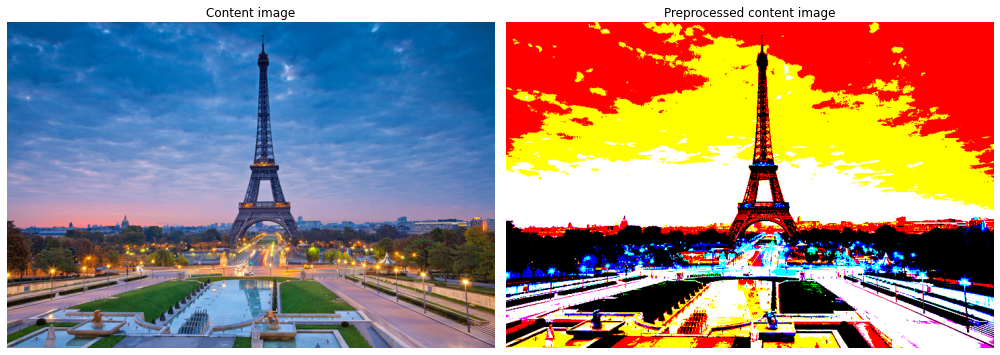

In [11]:
# Creating two subplots 
fig, axes = plt.subplots(1, 2, figsize=(14,7))

# Displaying content and preprocessed content images 
axes[0].imshow(content_image)
axes[0].set_title('Content image')
axes[0].axis('off')

axes[1].imshow(tf.keras.applications.vgg19.preprocess_input(content_image))
axes[1].set_title('Preprocessed content image')
axes[1].axis('off')

plt.tight_layout();

### Content outputs:

Obtaining the content outputs is pretty straighforward. Define a function that passes the preprocessed input image through our model and returns the *content_layers* outputs.   

In [12]:
def get_content_outputs(input_image):

    # Preprocess the input_image ( scale up input image by 255 )
    preprocessed_image = tf.keras.applications.vgg19.preprocess_input(input_image*255)
    
    # Store outputs of our custom model in outputs. Since we only 
    # need the outputs of the content_layers, only extract that. 
    # split_index determines the index that splits style from content layers 
    outputs = custom_VGG_model(preprocessed_image)[split_index:]

    # Return a dictionary of type { layer_name: layer_output for all layer_outputs}
    return { layer_name: values for layer_name, values in zip(content_layers, outputs)}

actual_content_outputs = get_content_outputs(resized_content_image)

### Style outputs:

Extracting the style of an image is not as simple as extracting its content. Before looking into why this is the case, lets see what a gram matrix is...

#### Gram Matrix:

Let us consider two vectors a, b. The dot product of these two vectors is given by, <br />

$a.b = \|a\|$.$\|b\|.\cos\Theta$

Dot product of a, b can be viewed as the length of the projected vector a on vector b times the length of the vector b or the length of vector a going in the same direction as vector b times the length of the vector b ( rearranging a.b.cos$\theta$ as (a.cos$\theta$).b). What this means is, the lesser the angle between these two vectors is, the greater their dot product will be. Intuitively, dot product can be used to measure the similarity between two vectors. The more similar they are, the lesser the angle between them is or the closer their respective coordinates are. In both the cases, the result is large. So the more similar they are, the larger their dot product gets.

Now, consider some style output for a single layer extracted from our custom model for a given image. If the shape of this output is of the form (1, 100, 100, 64), (here 1 represents the no.of images; Its always one in this case and can thus be ignored) this means that there are 64 100*100 matrices representing 64 different feature matrices / channels. 

Let channel C<sub>1</sub>, C<sub>2</sub> be the first two channels of this output. If C<sub>1</sub> gets activated (Here getting activated refers to it having a huge value compared to zero) for an image section containing orangish shades and C<sub>2</sub> for an image section containing yellowish circles, if for a particular section of the input image both C<sub>1</sub> and C<sub>2</sub> are highly activated, this could mean that that section contains an image of a sky with the sun in it. Essentially, there is a high correlation ( aka similarity ) between C<sub>1</sub> and C<sub>2</sub>. This similarity between all the 64 channels is captured using a *gram matrix*. 

Formally, the Gram matrix of a set of vectors $\mathbf{v}$<sub>1</sub> ... $\mathbf{v}$<sub>n</sub> in an inner product space is the Hermitian matrix of inner products, whose entries are given by $\mathbf{G}$<sub>ij</sub> $=$  <$\mathbf{v}$<sub>i</sub>, $\mathbf{v}$<sub>j</sub>>.

Basically, if we take C<sub>1</sub>, C<sub>2</sub> and flatten them ( call them $\mathbf{v}$<sub>1</sub>, $\mathbf{v}$<sub>2</sub>),<br />

$\mathbf{G}$<sub>12</sub> = dotproduct($\mathbf{v}$<sub>1</sub>, $\mathbf{v}$<sub>2</sub>).<br />

 Similary, $\mathbf{G}$<sub>13</sub> = dotproduct($\mathbf{v}$<sub>1</sub>, $\mathbf{v}$<sub>3</sub>) .... $\mathbf{G}$<sub>1 64</sub> = dotproduct($\mathbf{v}$<sub>1</sub>, $\mathbf{v}$<sub>64</sub>). <br />

 This gives us the correlation between C<sub>1</sub> and all C<sub>i</sub> where i = 1..64 channels.

 Finally, for one style layer output, Gram matrix $\mathbf{G}^\mathbf{L}$ is given as, <br /><br />

$\mathbf{G}^\mathbf{L}$ = $\begin{bmatrix} \mathbf{G}_{1 1} & \dots & \mathbf{G}_{1 n} \\ \vdots & \vdots & \vdots \\ \mathbf{G}_{n 1} & \dots & \mathbf{G}_{n n} \end{bmatrix}$<br />


 where, $\mathbf{L}$ denotes the layer's number. For style_layers it ranges from 1 to 5. It is pretty clear that $\mathbf{G}$ is an n*n matrix where n denotes the no.of channels / feature matrices for that particular layer. $\mathbf{G}$ can be calculated by multiplying a flattened feature matrix with its own transpose.


#### Why Gram matrix?

The next question is, why should we use gram matrices? During stylization, we are not interested in finding out the position or even the existence of specific features in the style image. We are more interested in finding out these feature distributions, and the correlation between those distributions so that, in essence, only information regarding the style is transfered to the final image.  

Gram matrices do exactly that. A gram matrix contains information regarding only the correlation between the channels/feature matrices.  The lesser the value, the lesser the two features co-occur and the greater it is, the more they co-occur. This, in a sense gives information about an image’s style(texture etc) and zero information about its spatial structure(position etc) since we already flatten the feature matrix.

***tf.reshape(tensor, shape=()) ***is used for reshaping a tensor.<br /><br />
***tf.transpose(tensor, []) ***is used for swapping axes in a tensor.<br /><br />
***tf.matmul(tensor1, tensor2, transpose_a = , transpose_b = ) ***is used for matrix multiplication.<br /><br />

In [13]:
def calculate_gram_matrix(tensor):

    # Obtain the shape of input_tensor. Here batch will always be 
    # one considering since we use only one image.  
    batch, height, width, channels = tensor.shape
    
    # reshape tensor to "flatten" it. batch, height, width, channels -> batch, height*width, channels  
    reshaped_tensor = tf.reshape(tensor, (batch, height*width, channels))

    # Swap reshaped_tensor's axis. 0, 1, 2 -> 0, 2, 1
    axis_swapped_tensor = tf.transpose(reshaped_tensor, [0, 2, 1])

    # gram matrix = tensor * tensor.T
    gram_matrix = tf.matmul(axis_swapped_tensor, axis_swapped_tensor, transpose_b=True)
    
    # Note: Instead of swapping the axis of reshaped_tensor, we can use it directly as well. 
    # Although in this case, gram matrix = tensor.T * tensor 
    #gram_matrix = tf.matmul(reshaped_tensor, reshaped_tensor, transpose_a=True)
    
    # Scale down gram_matrix's value by 'height*width' (not necessarily height*width; any arbitrary value 
    # can be used. 'height*width' scales down consistently irrespective the dimensions of the image). 
    # This step is not necessary as such. If ignored, 'style_weight' has to be set accordingly so 
    # that it doesnt affect our final image's content.
    scaled_gram_matrix = gram_matrix/ (height*width)
    
    return scaled_gram_matrix
    


In [14]:
def get_style_outputs(input_image):

    # Preprocess the input_image ( scale up input image by 255 )
    preprocessed_image = tf.keras.applications.vgg19.preprocess_input(input_image*255)
    
    # Store outputs of our custom model in outputs. Since we only 
    # need the outputs of the style_layers, only extract that. 
    # split_index determines the index that splits style from content layers 
    outputs = custom_VGG_model(preprocessed_image)[:split_index]

    # Calculate the gram_matrix for every single output in outputs
    outputs = [ calculate_gram_matrix(output) for output in outputs]

    # Return a dictionary of type { layer_name: layer_output for all layer_outputs}
    return { layer_name: values for layer_name, values in zip(style_layers, outputs)}

actual_style_outputs = get_style_outputs(resized_style_image)

During the stylization process, at each step, the training_image has to be fed to the model to obtain the necessary outputs. Using two seperate functions for getting content_layer_outputs and style_layer_outputs means preprocessing the image twice and feeding the training image to the model twice. This essentially makes the whole process two times slower. To avoid this, we can define a single function that return both the content_layer_outputs and style_layer_outputs. 

In [15]:
def get_model_outputs(input_image):

    # Preprocess the input_image ( scale up input image by 255 )
    preprocessed_image = tf.keras.applications.vgg19.preprocess_input(input_image*255)
    
    # Store outputs of our custom model in outputs.  
    outputs =  custom_VGG_model(preprocessed_image)

    # Store the style_layer_outputs in style_outputs 
    # and content_layer_outputs in content_outputs 
    style_outputs = outputs[:5]
    content_outputs = outputs[5:]

    # Calculate the gram_matrix for every single output in stylee_outputs
    style_outputs = [ calculate_gram_matrix(output) for output in style_outputs]

    # Return a dictionary of type { type: {layer_name: layer_output for all layer_outputs} for all types} 
    # Types are 'style' and 'content'
    return { 'style': {layer_name: values for layer_name, values in zip(style_layers, style_outputs)}, 'content': {layer_name: values for layer_name, values in zip                 (content_layers, content_outputs)}}

In [16]:
'''
Uncomment to use the previous function

example_outputs = get_model_outputs(resized_content_image)
ex_style_outputs = example_outputs['style'] # holds the style outputs
ex_content_outputs = example_outputs['content'] # holds the content outputs
print(ex_style_outputs)
print(ex_content_outputs)
''';

## Computing loss:

Next, we need to compute the loss between actual_content_outputs - training_content_outputs and actual_style_outputs - training_style_outputs using MSE( mean squared error ).


In the stylization process, both the style and content layer losses cannot be given equal importance because doing so would distort the actual content image itself. 

This is how the final image would look like if both the style and content losses are given equal weightage,

![image](images/stylized_image_equal_weights.jpg)

To avoid this, the style weight has to be lower than the content weight. Individual layer weights can also be used to define which layer has to be given more weightage than the others.

In [17]:
# Setting style and content weights. 
# Individual weights for content layers are not 
# set because there is only one layer in content_layers.
content_weight = 10000
style_weight = 1

# Initializing every single layer to 1 means they are all given equal weightage.
style_layer_weights = {'block1_conv1': 1, 'block2_conv1': 1, 'block3_conv1': 1, 'block4_conv1': 1, 'block5_conv1': 1}

'''
print('Overall Content Weight: ', content_weight)
print('Overall Style Weight: ', style_weight)
print('Style layer weights: ', style_layer_weights)
''';

Since eager execution is enabled by default in tensorflow 2.0, tf will calculate the value of tensors as the respective code lines are executed. So there isnt a precomputed graph as such to back propogate our losses to.

 This means the computations must be stored first and then applied to an optimiser. This is done using ***tf.GradientTape()***. It records all relevant operations executed inside the context of a tf.GradientTape with respect to some given input onto a "tape". This can later be used for calculating gradients, optimization etc..<br />

***with tf.GradientTape() as tape: *** provides the context. Every relevant operation executed inside this block is stored for later computations.<br />

***tape.gradient( loss, trainable_values) *** is used to calculate the gradients using computed loss and the training_data.<br />

***optimizer.apply_gradients() *** is used to apply the gradients.<br />

***tf.clip_by_value(tensor, clip_value_min=0.0, clip_value_max=1.0)*** restricts the minimum and maximum values of a tensor. In this case, any value below 0 is becomes 0 and any value above 1 becomes 1. This is done so that the values of our training_image stays within its allowed limits (As discussed above).


#### Total Variation Loss:

The total variation is the sum of the absolute differences for neighboring pixel-values in the input images. This measures how much noise is in the images. This can be used as a loss-function during optimization so as to suppress noise in images. 

***tf.image.total_variation(image): *** is used to calculate the total variation loss of an image. This can then be directly added to the style and content loss to produce *total_loss*.

The current training_image's output is obtained and seperated into style and content outputs. It is then compared to the actual style and content outputs to obtain the loss ( total variation can be added too ). This loss is then used to find the gradients, which are then passed to an optimizer to update the training_image. The training_image values are then clipped between 0 and 1. This completes one iteration of the stylization process.

In [18]:
# Adam optimizer is used in this implementation. 
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.9, beta_2 = 0.999, epsilon=1e-7)

In [19]:
# @tf.function() can be used to speed up eager mode executions
@tf.function()
def stylize_iteration(training_image):
    
    # tape is the name assigned for this tf.GradientTape()
    with tf.GradientTape() as tape:
        
        # Get the model outputs for training_image and
        # seperate them into style and content outputs.
        outputs = get_model_outputs(training_image)
        training_style_outputs = outputs['style']
        training_content_outputs = outputs['content']

        # Define temporary style and content MSE lists.
        style_MSE = []
        content_MSE = []
        
        # For every layer in style_layers, find the MSE of training_style_outputs and actual_style_outputs, 
        # find the mean of that matrix and multiply it with that particular layers's weight.
        for layer_name in style_layers:
            style_MSE.append( tf.reduce_mean( (training_style_outputs[layer_name] - actual_style_outputs[layer_name])**2 ) * style_layer_weights[layer_name] )
        
        # For every layer in content_layers, find the MSE of training_content_outputs and actual_content_outputs, 
        # find the mean of that matrix and multiply it with that particular layers's weight. In this case, there 
        # is only one layer in content_layers. 
        for layer_name in content_layers:
            content_MSE.append( tf.reduce_mean( (training_content_outputs[layer_name] - actual_content_outputs[layer_name])**2 ) )
        
        # Add all the MSE values of style and content layers. 
        # Since there are 5 style layers, we can divide the final loss_value by 5 to scale down 
        # its value. This step can be avoided by setting an appropriate style_weight as well.   
        style_loss = sum([ layer_MSE for layer_MSE in style_MSE] )/5
        content_loss = content_MSE[0] 

        # Add the weighted style and content loss.
        loss = style_loss*style_weight + content_loss*content_weight
        
        # Add total variation loss.
        total_loss = loss + 0
        # tf.image.total_variation(training_image)


    # Calculate the gradients
    gradients = tape.gradient(total_loss, training_image)
    
    # Apply the gradients
    optimizer.apply_gradients([(gradients, training_image)])
    
    # Clip values lesser than 0 and greater than 1
    training_image.assign(tf.clip_by_value(training_image, clip_value_min=0.0, clip_value_max=1.0))

## Defining Stylize function:

In [20]:
'''
Stylize function 
'''

# take as input the image to be stylized and 
# the no.of iterations
def stylize_image(image, iterations):
    
    # Resize the input image and convert it into a tf.Variable.
    training_image = tf.Variable(resize_image(image.copy()))

    # Run a for loop iterations times 
    for iteration in range(1, iterations+1):

        # Call stylize_iteration(training_image)
        stylize_iteration(training_image)

        # Uncomment to print intermediate training_image
        if iteration%100 == 0:
            display.clear_output(wait=True)
            print("Iteration ", iteration)
            display.display(show_image(training_image))
        
    
    return training_image

Iteration  1000


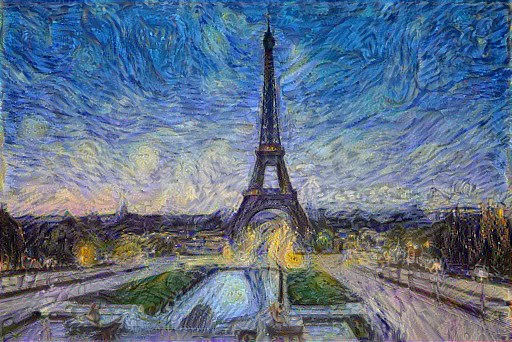

In [21]:
stylized_image = stylize_image(content_image, 1000)

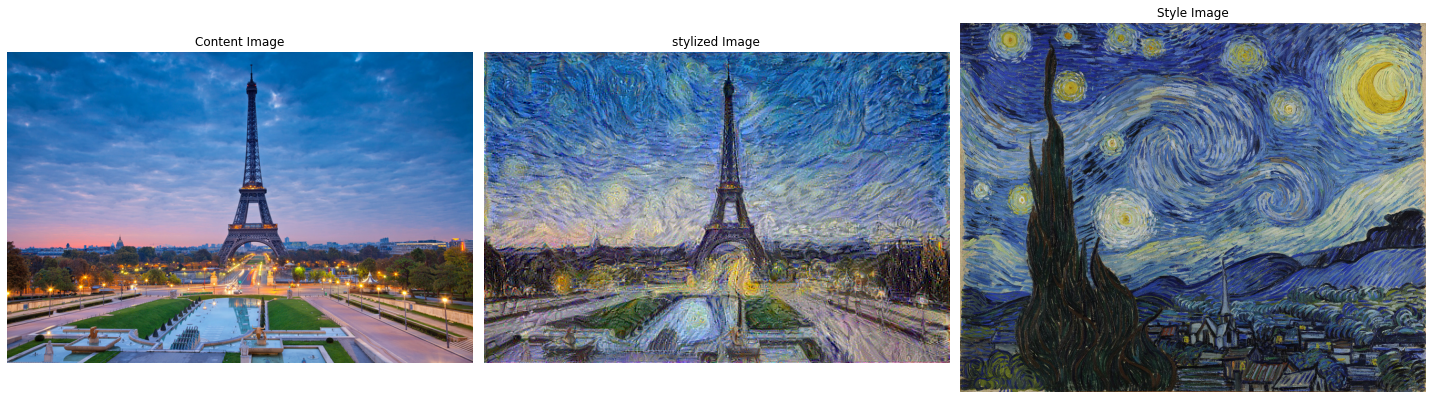

In [22]:
# Creating two subplots 
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Displaying content and style images 
axes[0].imshow(content_image)
axes[0].set_title('Content Image')
axes[0].axis('off')

axes[1].imshow(stylized_image.numpy()[0])
axes[1].set_title('stylized Image')
axes[1].axis('off')

axes[2].imshow(style_image)
axes[2].set_title('Style Image')
axes[2].axis('off')

plt.tight_layout()